In [12]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from Bio import SeqIO

In [13]:
## Code to test our script with known values
# df = pd.read_csv(r"C:\Users\JADVG3\Downloads\C3 plant_data.csv")
# print(df.shape)
# kcat_dropped = df.dropna(subset=['Kcat mean'], inplace=False)
# Sco_dropped = kcat_dropped.dropna(subset=['Sc/o\nmean'], inplace=False)
# print('Sco dropped shape:',Sco_dropped.shape)
# print('kcat dropped shape:',kcat_dropped.shape)
# print('df shape:',df.shape)
# target_kcat = Sco_dropped['Kcat mean']
# train_kcat = Sco_dropped.drop(columns=['Kcat mean', 'ProteinID', 'Fetched Data', 'Photosynthetic Type', 'Accession'])

# train_Sco = Sco_dropped.drop(columns=['Sc/o\nmean', 'ProteinID', 'Fetched Data', 'Photosynthetic Type', 'Accession'])
# target_Sco = Sco_dropped['Sc/o\nmean']

In [38]:
df = pd.read_csv(r"../Non-Mutated/Dependencies/merged_blind_protein_prott5.csv")
print(df.shape)
proteinId = df['ProteinID']
print(proteinId.shape)
embeddings = df.drop(columns=['ProteinID'])
print(embeddings.shape)

(56379, 1025)
(56379,)
(56379, 1024)


In [39]:
kcat = joblib.load(r"../Non-Mutated/Dependencies/ridgeModels/kcat mean 0.01.pkl")
sco = joblib.load(r"../Non-Mutated/Dependencies/ridgeModels/Sco mean 0.01.pkl")
kcat_predictions = kcat.predict(embeddings)
sco_predictions = sco.predict(embeddings)
kcat_predictions = pd.DataFrame(kcat_predictions, columns=['Kcat'])
sco_predictions = pd.DataFrame(sco_predictions, columns=['Sc/o'])
new_df = pd.concat([proteinId, kcat_predictions, sco_predictions], axis=1)
new_df.to_csv(r"../Non-Mutated/Output/predictions.tsv", sep='\t', index=False)

(2776, 1024)


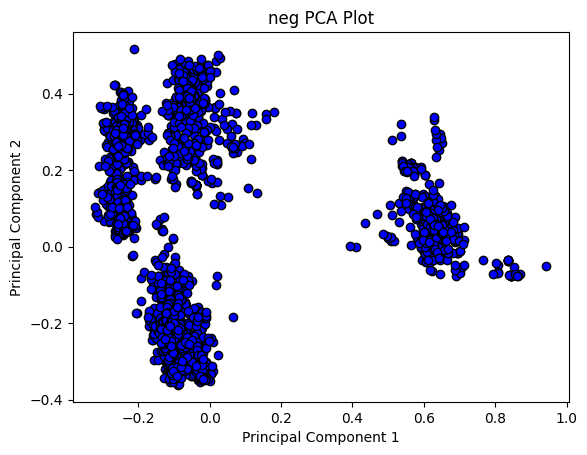

(53603, 1024)


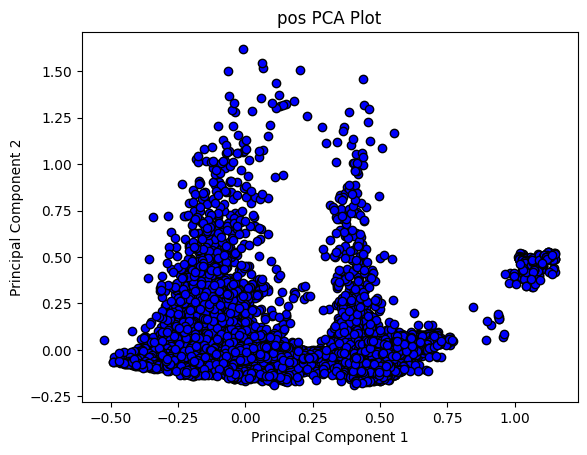

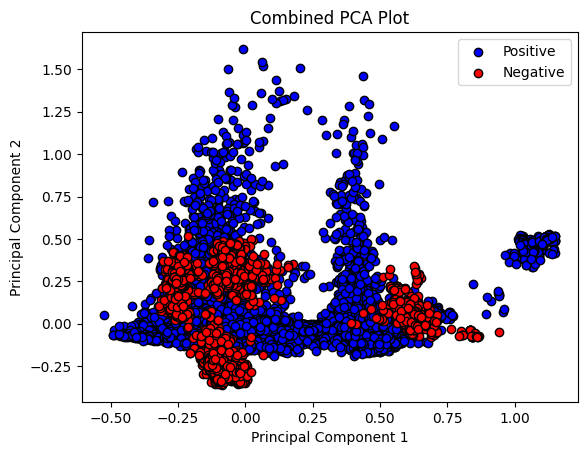

In [22]:
def show_PCA_plot():
    """
    Displays PCA plots for positive and negative embeddings.

    This function applies PCA (Principal Component Analysis) to reduce the dimensionality of the data and then plots the data points in the reduced dimensional space.

    Parameters:
    None

    Returns:
    None
    """

    # Generate Plot for negative data points
    negative_kcat_indexes = new_df.loc[new_df['Kcat'] < 0].index
    neg_embeddings = embeddings.loc[negative_kcat_indexes]
    
    print(neg_embeddings.shape)
    
    # Apply PCA to reduce the dimensionality of the data])
    neg_embeddings = np.array(neg_embeddings)
    pca = PCA(n_components=2)  # You can adjust the number of components as needed
    data_reduced = pca.fit_transform(neg_embeddings)

    # Plot the data points in the reduced dimensional space
    plt.scatter(data_reduced[:, 0], data_reduced[:, 1], c='blue', edgecolor='k')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('neg PCA Plot')
    plt.show()


    # Generate Plot for positive data points
    pos_embeddings = embeddings.loc[embeddings.index.difference(negative_kcat_indexes)]
    print(pos_embeddings.shape)

    # Apply PCA to reduce the dimensionality of the data])
    pos_embeddings = np.array(pos_embeddings)
    pca = PCA(n_components=2)  # You can adjust the number of components as needed
    data_reduced = pca.fit_transform(pos_embeddings)

    # Plot the data points in the reduced dimensional space
    plt.scatter(data_reduced[:, 0], data_reduced[:, 1], c='blue', edgecolor='k')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('pos PCA Plot')
    plt.show()


    # Generate Plot for both the data points combined
    pca = PCA(n_components=2)  # You can adjust the number of components as needed
    data_reduced_pos = pca.fit_transform(pos_embeddings)
    data_reduced_neg = pca.fit_transform(neg_embeddings)

    # Plot the data points in the reduced dimensional space
    plt.scatter(data_reduced_pos[:, 0], data_reduced_pos[:, 1], c='blue', edgecolor='k', label='Positive')
    plt.scatter(data_reduced_neg[:, 0], data_reduced_neg[:, 1], c='red', edgecolor='k', label='Negative')

    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('Combined PCA Plot')
    plt.legend()
    plt.show()

show_PCA_plot()

In [23]:
# List of amino acids that are rare or unknown so we can exclude them from our choice of amino acids``
exclusion_list = ['B', 'Z', 'J', 'O', 'U', 'X'] 

In [35]:
"""
Process sequences to obtain top unannotated predicted sequences.

This reads a FASTA file, filters the sequences based on certain criteria,
and writes the top unannotated predicted sequences to a new FASTA file.
"""
for i in range(10, len(new_df.index)):

    # Get the top 10 predictions values for Kcat with the exclusion of the exclusion list amino acids
    top_10_pred_kcat = new_df.nlargest(i, 'Kcat')
    top_pred = new_df.nlargest(i, 'Kcat')
    top_10_pred_kcat = top_10_pred_kcat['ProteinID']
    top_10_pred_kcat = np.array(top_10_pred_kcat)
    top_10_pred_kcat = [string.replace(">", "") for string in top_10_pred_kcat]

    # Specify the path to the FASTA file
    fasta_file = r"../Non-Mutated/Dependencies/merged.fasta"
    topseq = pd.DataFrame()
    # Read the FASTA file
    sequences = SeqIO.parse(fasta_file, "fasta")
    
    top_sequences = []
    total_sequences = []
    # Iterate over the sequences
    for sequence in sequences:
        # Access the sequence ID and sequence data
        sequence_desc = sequence.description
        sequence_data = sequence.seq
        if any(char in sequence_data for char in exclusion_list):
            continue
        if sequence_desc not in top_10_pred_kcat:
            continue
        # Do something with the sequence ID and sequence data
        print(f"Sequence ID: {sequence_desc}")
        print(f"Sequence Data: {sequence_data}")
        top_sequences.append(sequence)
        total_sequences.append(sequence)
    print()
    print(len(top_sequences))
    if len(top_sequences) == 10:
        break

output_file = r"../Non-Mutated/Output/top_unanotated_pred_sequences.fasta"

# Write the sequences to the new FASTA file
SeqIO.write(top_sequences, output_file, "fasta")

Sequence ID: gi|313473685|dbj|BAJ40208.1| ribulose-1,5-bisphosphate carboxylase/oxygenase large subunit, partial (chloroplast) [Selaginella uncinata]
Sequence Data: YTPDYETQATDIPAASRTTPQPGAPAEEAGAAVAAESSTGTWTTVWTDGLTNLDRYKGRCYDIEPVPGEKDQYIAYAAHPSDPFEEGSVTNMSTSIVGNVSGSKASRALRSEDLRIPPAYSKTFKGPPHGIQVERDKLNKHGRPSLGCTIKPKLGLSAKNYGRAAYERLRGGLDFTKDDENVNPQPFMRRRDRFVSVAEALNKAQAETGEIKGHHLNATAGARDETMKRAESARESGVPTAMHDHSTGGFTANTSLAYHCRDNGLLPHIHRATHAVIDRQRNHGTHPRVSAKASRTSGGDHIHAGTVVGKLEGERQVTLGFADLLRDDHIDKDRSRGIHPTQDWVSMPGVPPVASGGIHVRHMPALTEIFGDDSALQPGGGTSGHPWGNAPGAVANRVALEA
Sequence ID: gi|932248269|gb|ALG62965.1| ribulose-1,5-bisphosphate carboxylase/oxygenase large subunit, partial (chloroplast) [Selaginella pseudopaleifera]
Sequence Data: YRLTHYTPDYETQATDIPAASRTTPQPGAPAEEAGAAVAAESSTGTWTTVWTDGLTNLDRYKGRCYDIEPVPGEKDQYIAYAAHPSDPFEEGSVTNMSTSIVGNVSGSKASRALRSEDLRIPPAYSKTFKGPPHGIQVERDKSNKHGRPSLGCTTKPKLGLSAKNYGRAAYERLRGGLDFTKDDENVNPQPFMRRRDRFVSVAEALYKAQAETGEIKGHHLNATAGARDETMKRAESARESGVPTAMHDHSTGGFTANTSL

10

In [36]:
"""
Process sequences to obtain top annotated predicted sequences.

This reads a FASTA file, filters the sequences based on certain criteria,
and writes the top unannotated predicted sequences to a new FASTA file.
"""
all = pd.read_csv(r"../Non-Mutated/Dependencies/my_data.csv")
for i in range(10, len(all.index)):
    
    top_10_ano_kcat = all.nlargest(i, 'Kcat mean')
    print(top_10_ano_kcat)
    top_10_ano_kcat = top_10_ano_kcat['ProteinID']
    top_10_ano_kcat = np.array(top_10_ano_kcat)
    top_10_ano_kcat = [string.replace(">", "") for string in top_10_ano_kcat]
    exclusion_list = ['B', 'Z', 'J', 'O', 'U', 'X'] # XZBJ added
    # Read the FASTA file
    sequences = SeqIO.parse(fasta_file, "fasta")

    top_sequences = []
    # Iterate over the sequences
    for sequence in sequences:
        # Access the sequence ID and sequence data
        sequence_desc = sequence.description
        sequence_data = sequence.seq
        if any(char in sequence_data for char in exclusion_list):
            continue
        if sequence_desc not in top_10_ano_kcat:
            continue
        # Do something with the sequence ID and sequence data
        print(f"Sequence ID: {sequence_desc}")
        print(f"Sequence Data: {sequence_data}")
        top_sequences.append(sequence)
        total_sequences.append(sequence)
    print()
    print(len(top_sequences))
    if len(top_sequences) == 10:
        break

output_file = r"../Non-Mutated/Output/top_anotated_sequences.fasta"

# Write the sequences to the new FASTA file
SeqIO.write(top_sequences, output_file, "fasta")

          sv1       sv2       sv3       sv4       sv5       sv6       sv7  \
170  0.104880  0.142508  0.005541  0.001074  0.014252  0.053481 -0.074776   
55   0.109324  0.147310  0.006724 -0.003785  0.012947  0.054463 -0.073380   
131  0.087171  0.131459  0.012867 -0.016669  0.002686  0.041452 -0.063799   
135  0.106511  0.146515  0.009144 -0.015167  0.003495  0.049709 -0.075009   
154  0.110545  0.152548  0.002616 -0.006082  0.006671  0.050857 -0.078823   
147  0.107255  0.148716  0.004500 -0.001646  0.008772  0.055833 -0.076307   
148  0.107044  0.148412  0.004852 -0.001568  0.008280  0.055708 -0.076038   
27   0.110835  0.146954  0.004914 -0.009177  0.005580  0.052286 -0.076581   
29   0.108231  0.145977  0.005915 -0.010828  0.003572  0.051447 -0.076833   
139  0.102138  0.146597  0.006545 -0.003917  0.005526  0.051519 -0.072759   

          sv8       sv9      sv10  ...    sv1021    sv1022    sv1023  \
170 -0.048210 -0.074927 -0.080969  ... -0.013981  0.033988 -0.015223   
55  -0.0

10

In [37]:
output_file = r"../Non-Mutated/Output/top_sequences.fasta"

# Write the sequences to the new FASTA file
SeqIO.write(total_sequences, output_file, "fasta")

20